# Attempt at learning to ignore signals

In [32]:
from hrr import *
from Agent import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [33]:
color_set = ["red", "green"]
fake_signals = ["yellow"]

maze_size = 20
row_size = 4

goals = [4,7]

hrr_size = 1024 # Dimensionality of the HRRs (minimum 10x maze_size)

# All now pre-assigned in Agent, but can be overwritten in constructor
policy_gamma = 0.9 # Delayed reward coefficient 
policy_alpha = 0.001 # Learning rate
policy_epsilon = 0.03 # Random action chance
policy_lambda = 0.1 # delta affector

epochs = 1000 
max_moves = maze_size

ltm = LTM(N=hrr_size, normalized=True, M=1)
yellow_steps = []

choice_function = np.mean 

In [34]:
actor = Agent(["left", "right", "up", "down"], 32, ltm)
i_gate = Agent(["open", "close"], 8, ltm)
o_gate = Agent(["open", "close"], 8, ltm)

In [35]:
for epoch in range(epochs):
    current_state = np.random.choice(maze_size)
    goal_idx = np.random.choice(range(len(color_set)))
    steps_with_yellow = 0
    current_signal = color_set[goal_idx]
    fake_signal = fake_signals[np.random.choice(range(len(fake_signals)))]
    
    current_wm = "I"
    wm_slot = "I"
    
    if(epoch+1) % 10 == 0:
        print('\rEpisode:', (epoch+1), end='')
        
    for step in range(max_moves):
        if current_state == goals[goal_idx]:
            break

        if (step+1) % 5 == 0 and step != 0:
            current_signal = fake_signal
        
        if current_signal != "I":
            i_gate.policy(current_state, current_signal, current_wm)
        
            if i_gate.current_action == i_gate.action_set[0]:
                wm_slot = current_signal
                
        o_gate.policy(current_state, current_signal, current_wm)
            
        if o_gate.current_action == o_gate.action_set[0]:
            current_wm = wm_slot
        
        actor.policy(current_state, current_signal, current_wm)
        
        prev_state = current_state
        
        if actor.current_action == actor.action_set[0]:
            current_state = current_state-1
            current_state = current_state+row_size if (current_state+1) % row_size == 0 else current_state
        elif actor.current_action == actor.action_set[1]:
            current_state = (current_state+1)
            current_state = current_state-row_size if current_state % row_size == 0 else current_state
        elif actor.current_action == actor.action_set[2]:
            current_state = (current_state-row_size)%maze_size
        elif actor.current_action == actor.action_set[3]:
            current_state = (current_state+row_size)%maze_size
            
        is_goal = current_state == goals[goal_idx]
            
        actor.update(current_state, current_signal, current_wm, is_goal)
        if current_signal != "I":
            i_gate.update(current_state, current_signal, current_wm, is_goal)
        o_gate.update(current_state, current_signal, current_wm, is_goal)
            
        current_signal = "I"
        if current_wm == "yellow":
            steps_with_yellow += 1

    yellow_steps.append(steps_with_yellow)

Episode: 1000

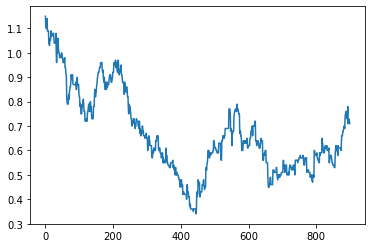

In [36]:
window_size = 100
data = [np.mean(yellow_steps[x:x+window_size]) for x in range(len(yellow_steps) - window_size)]
plt.plot(data)
plt.show()